# Chapter 6. Boolean functions, evasiveness, and MLPs

Some WIP sketches on Relu-MLP-as-decision-tree as a boolean function thus simplicial complex, and whether evasiveness has a meaningful intepretation.

The "Neural Networks as Decision Trees" line of work is largely problematic due to the size of the trees and that they don't apply to modern activation functions (GELU etc). Alas, there might be something in quantifying evasivness of, say, a single-layer MLP with ReLU activation.

References:
* [Neural Networks are Decision Trees
](https://arxiv.org/abs/2210.05189)

In [1]:
import torch
import numpy as np
import torch.nn as nn

class MLP(nn.Module):
    def __init__(self, input_dim, hidden_dim, output_dim):
        super(MLP, self).__init__()
        self.fc1 = nn.Linear(input_dim, hidden_dim, bias=True)
        self.relu = nn.ReLU()
        self.fc2 = nn.Linear(hidden_dim, output_dim, bias=True)
        
    def forward(self, x):
        x = self.fc1(x)
        x = self.relu(x)
        x = self.fc2(x)
        return x


In [2]:

# Define the XOR dataset
X = np.array([[0, 0], [0, 1], [1, 0], [1, 1]]) - 0.5
y = np.array([0, 1, 1, 0])

# Print the dataset
print("Input:")
print(X)
print("Output:")
print(y)


Input:
[[-0.5 -0.5]
 [-0.5  0.5]
 [ 0.5 -0.5]
 [ 0.5  0.5]]
Output:
[0 1 1 0]


In [3]:
mlp = MLP(input_dim=2, hidden_dim=5, output_dim=2)

# Define the loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(mlp.parameters(), lr=0.001)

# Define the number of epochs
num_epochs = 400

# Training loop
for epoch in range(num_epochs):
    # Forward pass
    outputs = mlp(torch.Tensor(X))
    loss = criterion(outputs, torch.Tensor(y).long())

    # Backward and optimize
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    # Print the loss for every 10 epochs
    if (epoch+1) % 10 == 0:
        print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {loss.item():.4f}')


/Users/jseely/miniconda3/envs/myenv2/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Epoch [10/400], Loss: 0.7268
Epoch [20/400], Loss: 0.7197
Epoch [30/400], Loss: 0.7136
Epoch [40/400], Loss: 0.7085
Epoch [50/400], Loss: 0.7040
Epoch [60/400], Loss: 0.7001
Epoch [70/400], Loss: 0.6965
Epoch [80/400], Loss: 0.6931
Epoch [90/400], Loss: 0.6899
Epoch [100/400], Loss: 0.6867
Epoch [110/400], Loss: 0.6836
Epoch [120/400], Loss: 0.6805
Epoch [130/400], Loss: 0.6773
Epoch [140/400], Loss: 0.6741
Epoch [150/400], Loss: 0.6707
Epoch [160/400], Loss: 0.6676
Epoch [170/400], Loss: 0.6647
Epoch [180/400], Loss: 0.6616
Epoch [190/400], Loss: 0.6581
Epoch [200/400], Loss: 0.6541
Epoch [210/400], Loss: 0.6495
Epoch [220/400], Loss: 0.6442
Epoch [230/400], Loss: 0.6383
Epoch [240/400], Loss: 0.6316
Epoch [250/400], Loss: 0.6241
Epoch [260/400], Loss: 0.6158
Epoch [270/400], Loss: 0.6065
Epoch [280/400], Loss: 0.5965
Epoch [290/400], Loss: 0.5858
Epoch [300/400], Loss: 0.5751
Epoch [310/400], Loss: 0.5640
Epoch [320/400], Loss: 0.5526
Epoch [330/400], Loss: 0.5417
Epoch [340/400], Lo

In [4]:
# Compute the classification accuracy
y_pred = torch.argmax(mlp(torch.Tensor(X)), dim=1)

In [5]:
import matplotlib.pyplot as plt

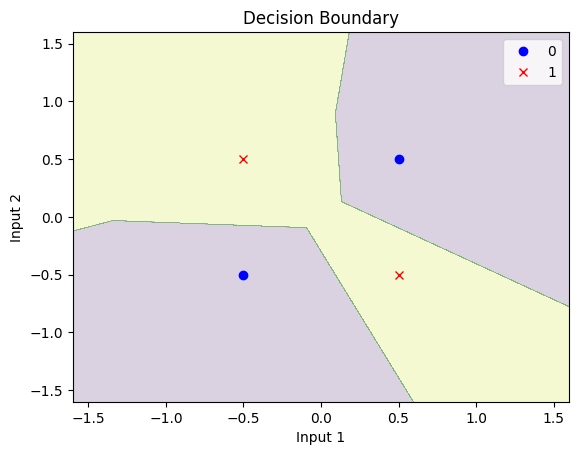

In [6]:
# Generate a grid of points in the input space R2
x_min, x_max = X[:, 0].min() - 1.1, X[:, 0].max() + 1.1
y_min, y_max = X[:, 1].min() - 1.1, X[:, 1].max() + 1.1
xx, yy = np.meshgrid(np.arange(x_min, x_max, 0.001),
                     np.arange(y_min, y_max, 0.001))
grid_points = np.c_[xx.ravel(), yy.ravel()]

# Pass each point through the trained MLP model to get the predicted class
with torch.no_grad():
    predictions = torch.argmax(mlp(torch.Tensor(grid_points)), dim=1)

# Plot the grid points and color them according to the predicted class
plt.figure()
plt.contourf(xx, yy, predictions.numpy().reshape(xx.shape), alpha=0.2)

# Overlay the input data points on the plot
plt.plot(X[y==0, 0], X[y==0, 1], 'ob', label='0')
plt.plot(X[y==1, 0], X[y==1, 1], 'xr', label='1')

plt.xlabel('Input 1')
plt.ylabel('Input 2')
plt.title('Decision Boundary')
plt.legend()
plt.show()


## NNs as DTs

In [8]:
params = [p for p in mlp.parameters()]

In [9]:
from copy import deepcopy

W1 = params[0].detach().numpy()
b1 = params[1].detach().numpy()
Q1 = deepcopy(np.concatenate([W1, b1[:, None]], axis=-1))

W2 = params[2].detach().numpy()
b2 = params[3].detach().numpy()
Q2 = deepcopy(np.concatenate([W2, b2[:, None]], axis=-1))

In [10]:
# layer 0
a = []

W_hat = deepcopy(W1)

x = X[0]
for j in range(W1.shape[0]):
    r = np.dot(W1[j, :], x) + b1[j]
    a.append(int(r > 0))

In [11]:
np.array(a) * b1

array([-0.00000000e+00,  5.03501296e-01,  9.60305184e-02, -1.89812272e-06,
        6.32721066e-01])

In [12]:
W1_eff = W1 * np.array(a)[:, None]

In [13]:
x_out_eff = W1_eff @ x + np.array(a) * b1


In [14]:
mlp(torch.Tensor(X[0]))

tensor([ 0.3880, -0.1329], grad_fn=<ViewBackward0>)

In [15]:
W2 @ x_out_eff + b2

array([ 0.3879617 , -0.13291888])

In [16]:
W_eff = W2 @ ((W1 * np.array(a)[:, None]))

In [17]:
mlp(torch.Tensor(x))

tensor([ 0.3880, -0.1329], grad_fn=<ViewBackward0>)

In [18]:
W_eff @ x + b2

array([ 0.7191323 , -0.54716467])

Relu MLP as decision tree:

For relu network that maps R^n -> R^m -> R^p

We have m-many comparisons of first layer.
For 2nd layer, there are 2^m possible filters for W_hat.
So we have 2^m many comparisons..

So about 2^m total nodes.

For a given input/query x, we go through m decisions first. Then that immediatley rules out a bunch of future notes, since our filter is defined. But just for this one query.

Mapping onto boolean fn chapter -- not super obvious how to do so.
- for each input we have m queries we can ask first.
- seeker wants to know if sigma is in m.... a simplex here corresponds to a set of comparisons?
- hmm, not sure what this maps out to.